In [ ]:
!pip install convertdate
!pip install openpyxl
!pip install  fbprophet holidays  pyluach


  Using cached fbprophet-0.7.1.tar.gz (64 kB)
  Preparing metadata (setup.py) ... done
  Using cached cmdstanpy-0.9.5-py3-none-any.whl (37 kB)
  Using cached pystan-3.9.1-py3-none-any.whl (13 kB)
  Using cached LunarCalendar-0.0.9-py2.py3-none-any.whl (18 kB)
  Using cached setuptools_git-1.2-py2.py3-none-any.whl (10 kB)
  Using cached ephem-4.1.5-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.8 MB)
  Using cached clikit-0.6.2-py2.py3-none-any.whl (91 kB)
  Using cached httpstan-4.12.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (45.3 MB)
  Using cached pysimdjson-6.0.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.8 MB)
  Using cached crashtest-0.3.1-py3-none-any.whl (7.0 kB)
  Using cached pastel-0.2.1-py2.py3-none-any.whl (6.0 kB)
  Using cached pylev-1.4.0-py2.py3-none-any.whl (6.1 kB)
  Using cached appdirs-1.4.4-py2.py3-none-any.whl (9.6 kB)
  Using cached marshmallow-3.21.2-py3-none-any.whl (49 kB)
  Using cached webargs-8.4.0-py3-no

In [ ]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
import matplotlib
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
import seaborn as sns
from statsmodels.graphics import tsaplots
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.dates as mdates
from prophet import Prophet
from fbprophet import Prophet
from pyluach import dates, hebrewcal
import holidays
from google.colab import drive

ModuleNotFoundError: No module named 'fbprophet'

###Mout google drive

In [ ]:
drive.mount('/content/drive/', force_remount=True)
file_path = '/content/drive/My Drive/project data.csv'
df = pd.read_csv(file_path)

Mounted at /content/drive/


##Data preproces - loading, pattern recognition, diffrentiating, outlieres check

In [ ]:
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
weekly_data = df.resample('W-SAT').sum() # Resample the data by week. 'W-SAT' means weeks ending on Saturday.
weekly_data = weekly_data.iloc[1:]  # Remove the first row if it does not represent a complete week
cutoff_date = pd.Timestamp('2020-03-01')# Set cutoff date to remove empty data entries after this point
weekly_data = weekly_data[weekly_data.index < cutoff_date]


####Load

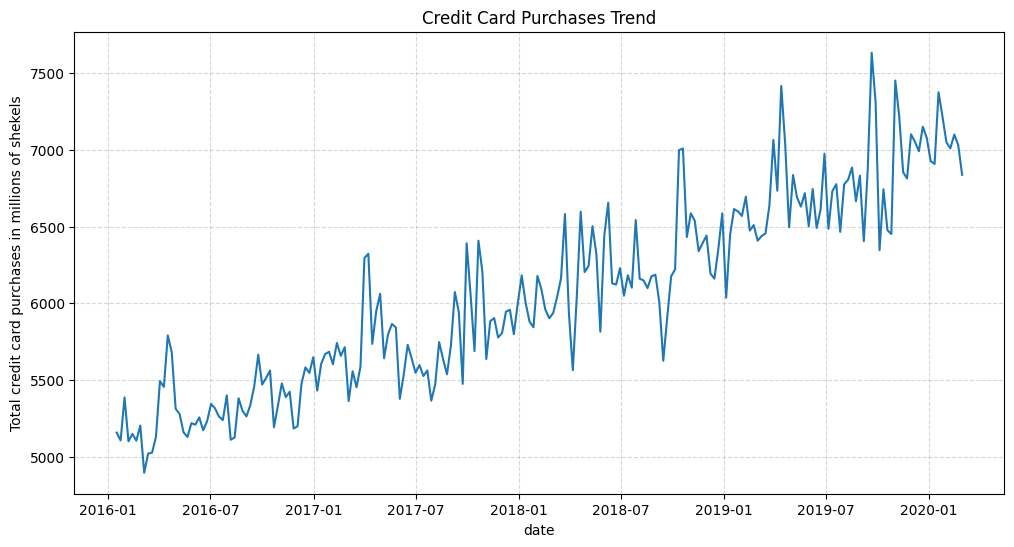

In [ ]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=weekly_data, x='date', y='Total credit card purchases in millions of shekels')
plt.title("Credit Card Purchases Trend")
plt.grid(True, linestyle='--', alpha=0.5)

#### Understand the pattern by ploting the data per year

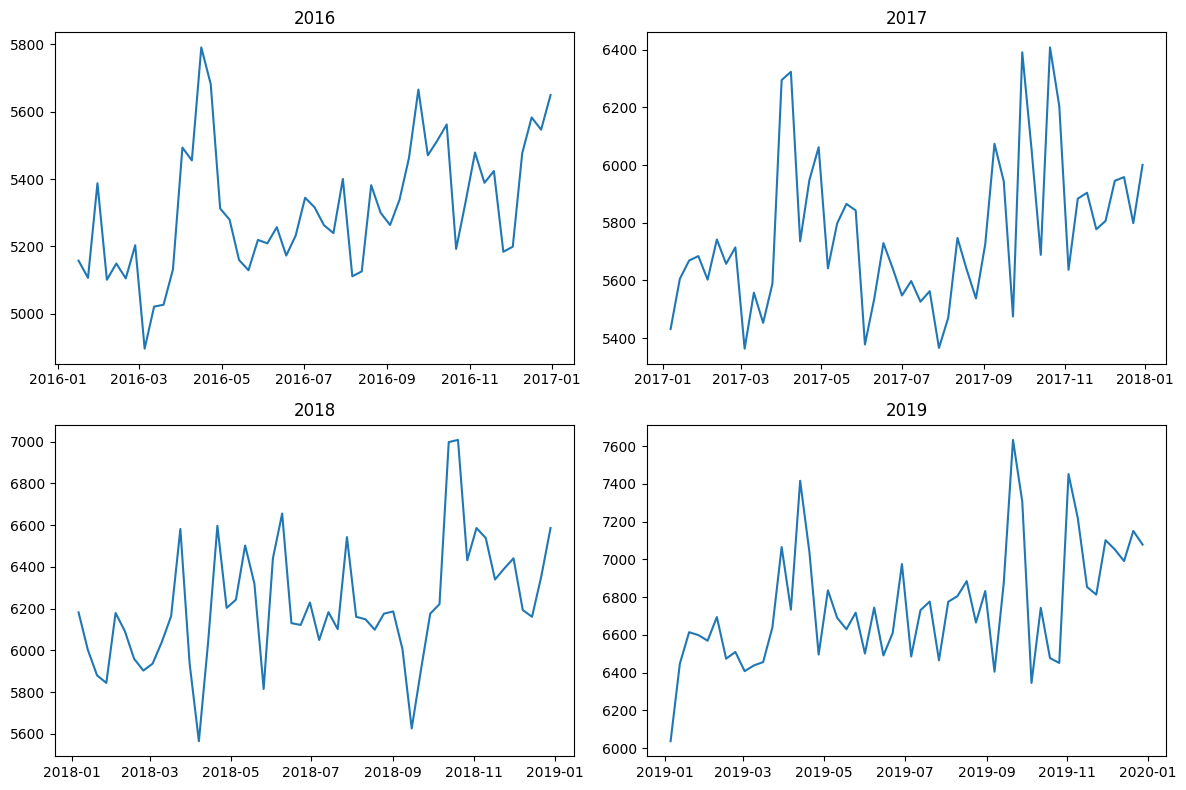

In [ ]:
# Create subplots for each year
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
axs = axs.flatten()  # Flatten the array for easier iteration

# Loop over the years and plot data
for i, year in enumerate(range(2016, 2020)):
    data = weekly_data[weekly_data.index.year == year]
    axs[i].plot(data.index, data['Total credit card purchases in millions of shekels'])
    axs[i].set_title(str(year))

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

### conclusion :

The Hebrew calendar is 355 days long and every four years there is a leap year in which an additional month is added, making it 385 days. In a leap year, Passover occurs in May rather than April. It can be observed that 2018 was a leap year because there is no local maximum point in April, but there is one in May. From the tests we conducted for data not converted to the Hebrew date, we received significant partial autocorrelation for lags 1 to 60. In order to avoid this, we will attempt to transition to using the Hebrew date. Therefore, in order for the model to run well, we will switch to the Hebrew calendar.

## convert dates to hebrew calnder to fit the data better then the georgian

In [ ]:
from convertdate import hebrew

def gregorian_to_hebrew(timestamp):
    year, month, day = timestamp.year, timestamp.month, timestamp.day
    hebrew_date = hebrew.from_gregorian(year, month, day)
    return f'{hebrew_date[0]}-{hebrew_date[1]:02d}-{hebrew_date[2]:02d}'


weekly_data.index = weekly_data.index.map(gregorian_to_hebrew)
weekly_data = weekly_data.reset_index()
weekly_data.rename(columns={'index': 'date'}, inplace=True)


In [ ]:
weekly_data['year'] = weekly_data['date'].apply(lambda x: int(x.split('-')[0])) #extract year
weekly_data['month'] = weekly_data['date'].apply(lambda x: int(x.split('-')[1]))  # Extract month


#### in the hebrew calander has slightly less days then the georgian, Thus once in 4 years there is a leaped year with 13 months. we will analys which of our data yers is leaped and which is not

In [ ]:
def is_hebrew_leap_year(year):
    return (year * 7 + 1) % 19 < 7

years_list = list({year for year in weekly_data['year']})
for year in years_list:
  print(f"Hebrew year {year} is a leap year: {is_hebrew_leap_year(year)}")

Hebrew year 5776 is a leap year: True
Hebrew year 5777 is a leap year: False
Hebrew year 5778 is a leap year: False
Hebrew year 5779 is a leap year: True
Hebrew year 5780 is a leap year: False


In [ ]:
# Hebrew month names mapping
hebrew_months_regular = {
    '01': 'ירשת', '02': 'ןוושח', '03': 'ולסכ', '04': 'תבט',
    '05': 'טבש', '06': 'רדא', '07': 'ןסינ', '08': 'רייא',
    '09': 'ןויס', '10': 'זומת', '11': 'בא', '12': 'לולא'
}

hebrew_months_leap = {
    '01': 'ירשת', '02': 'ןוושח', '03': 'ולסכ', '04': 'תבט',
    '05': 'טבש', '06': 'א רדא', '07': 'רדא ב', '08': 'ןסינ',
    '09': 'רייא', '10': 'ןויס', '11': 'זומת', '12': 'בא', '13': 'לולא'
}

In [ ]:
hebrew_months_leap = {
    '01': 'Nissan', '02': 'Iyar', '03': 'Sivan',
    '04': 'Tammuz', '05': 'Av', '06': 'Elul',
    '07': 'Tishrei', '08': 'Cheshvan', '09': 'Kislev',
    '10': 'Tevet', '11': 'Shvat', '12': 'Adar',
    '13': 'Adar II'
}

hebrew_months_regular = {
    '01': 'Nissan', '02': 'Iyar', '03': 'Sivan',
    '04': 'Tammuz', '05': 'Av', '06': 'Elul',
    '07': 'Tishrei', '08': 'Cheshvan', '09': 'Kislev',
    '10': 'Tevet', '11': 'Shvat', '12': 'Adar',
}

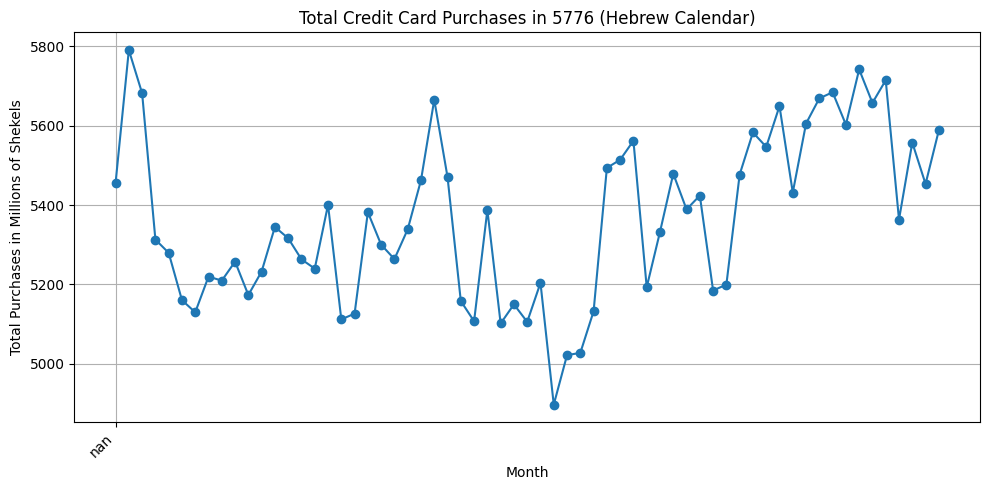

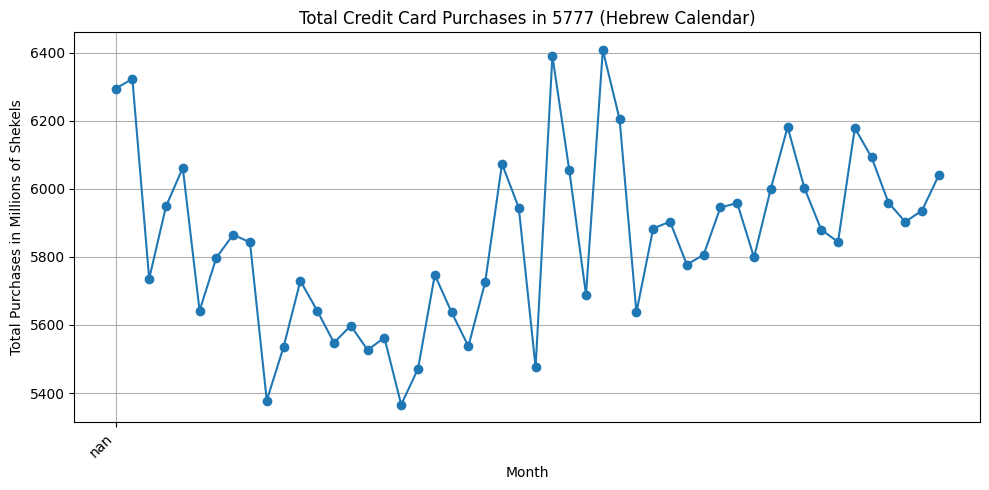

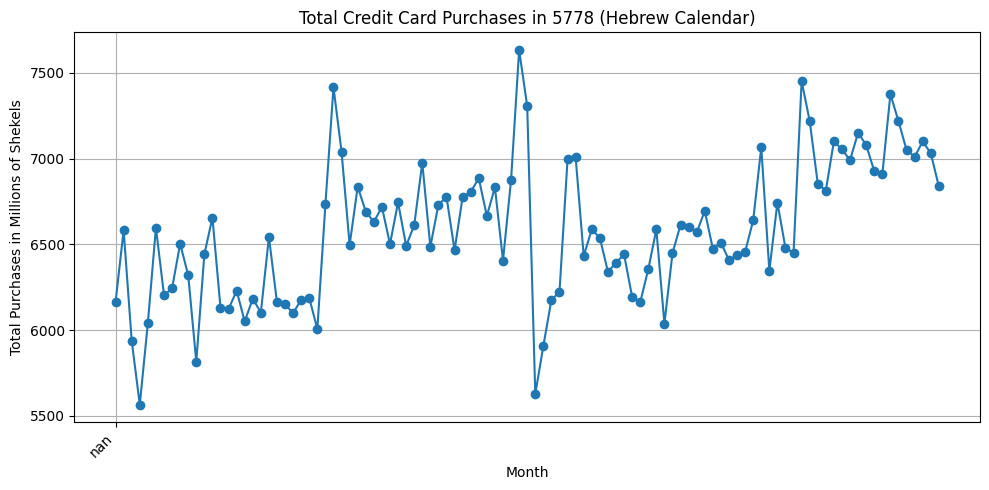

In [ ]:
leap_years = {'5776', '5779'}

# Determine if a year is a leap year
def is_leap_year(year):
    return year in leap_years

# Plotting setup for each year
for year in weekly_data['year'].unique():
    data_for_year = weekly_data[weekly_data['year'] == year]
    data_for_year = data_for_year.sort_values('date')

    # Determine the month mapping to use based on leap year
    month_mapping = hebrew_months_leap if is_leap_year(year) else hebrew_months_regular
    data_for_year['month_name'] = data_for_year['month'].map(month_mapping)

    # Find the unique, first occurrence of each month to use as x-ticks
    unique_months = data_for_year.drop_duplicates('month_name', keep='first')

    plt.figure(figsize=(10, 5))
    plt.plot(data_for_year['date'], data_for_year['Total credit card purchases in millions of shekels'], marker='o')
    plt.title(f'Total Credit Card Purchases in {year} (Hebrew Calendar)')
    plt.xlabel('Month')
    plt.ylabel('Total Purchases in Millions of Shekels')
    plt.grid(True)

    # Set x-ticks at the positions of the first occurrence of each month
    plt.xticks(unique_months['date'], unique_months['month_name'], rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

### Decomposition is perhaps the most artistic act in time series analysis, as it requires a deep understanding of the underlying patterns in the data. One of the key factors in this process is successfully decomposing the trend. Most of the time, when we succeed in identifying the trend, we are on the right track.

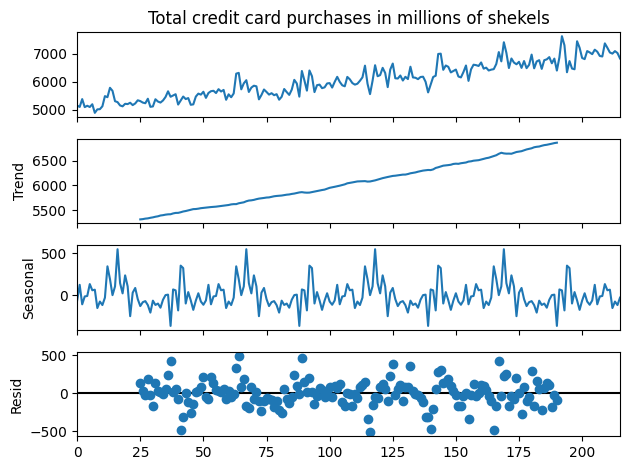

In [ ]:
decomposition=seasonal_decompose(weekly_data['Total credit card purchases in millions of shekels'],model='additive',period=51)
decomposition.plot()
plt.show()

In [ ]:
data_diff=weekly_data['Total credit card purchases in millions of shekels'].diff(periods=51)
# the number is 51 since in the hebrew calander there are 51 weeks

dftest = adfuller(data_diff.dropna(), autolag = 'AIC')
print("1. ADF : ",dftest[0])
print("2. P-Value : ", dftest[1])
print("3. Num Of Lags : ", dftest[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
    print("\t",key, ": ", val)

1. ADF :  -4.28540979412886
2. P-Value :  0.00047077704834336183
3. Num Of Lags :  9
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 155
5. Critical Values :
	 1% :  -3.4732590518613002
	 5% :  -2.880374082105334
	 10% :  -2.5768120811654525


## Hyperparameters Tuning
## When manually tuning hyperparameters, I explored several options. Typically, this task can be automated using grid search, ensuring that the values chosen are relevant to real-world scenarios. For instance, hyperparameters are often tested within a range, such as between 0 and 3, depending on the specific context

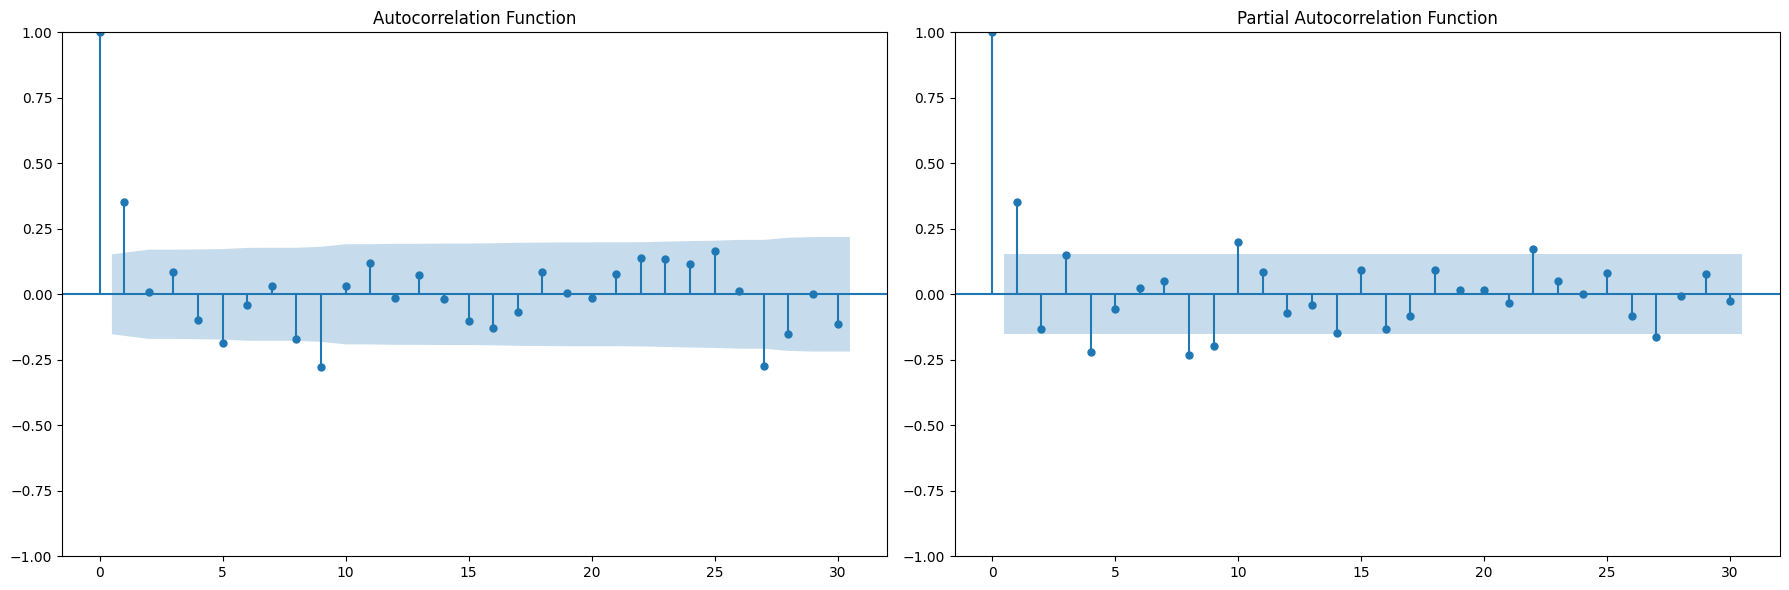

In [ ]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Remove NaN values to ensure the functions work properly
data_diff_nonan = data_diff.dropna()

# Create a figure with two subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

# Plot the Autocorrelation Function (ACF)
plot_acf(data_diff_nonan, lags=30, alpha=0.05, ax=axes[0])  # Using 30 lags and 95% confidence interval
axes[0].set_title('Autocorrelation Function')

# Plot the Partial Autocorrelation Function (PACF)
plot_pacf(data_diff_nonan, lags=30, alpha=0.05, method='ywm', ax=axes[1])  # Yule-Walker with bias correction
axes[1].set_title('Partial Autocorrelation Function')

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()


Thus, based on these results, the time series appears to be stationary, meaning it does not have a unit root, and shows properties such as constant mean and variance over time.

diffrentiare by one year.

In [ ]:
weekly_data = weekly_data.set_index('date')

In [ ]:
weekly_data = weekly_data.drop(['year'], axis=1)
weekly_data = weekly_data.drop(['month'], axis=1)
weekly_data

,Total credit card purchases in millions of shekels
date,
5776-11-06,5157.9
5776-11-13,5106.8
5776-11-20,5387.5
5776-11-27,5101.2
5776-12-04,5149.4
...,...
5780-11-06,7049.9
5780-11-13,7010.1
5780-11-20,7099.6


In [ ]:
weekly_data.rename(columns={'Total credit card purchases in millions of shekels': 'purches'}, inplace=True)


The plot's baseline hovering around a higher value (e.g., around 500) indicates that the data, after this operation, still exhibits a trend or a shift from the original baseline (zero in case of seasonality plots). This shift could be due to the nature of the differences calculated, where if the dataset originally had a growing or declining trend, the differences could reflect this trend not as a fluctuation around zero but shifted upwards or downwards.

the first spike in both of the graphs hints AR(1) and MA(1)
moreover D=1 and d=51

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:559: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  _index = to_datetime(index)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:559: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  _index = to_datetime(index)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local

                               SARIMAX Results                                
Dep. Variable:                purches   No. Observations:                  216
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -1501.554
Date:                Sat, 25 May 2024   AIC                           3011.107
Time:                        08:24:40   BIC                           3024.608
Sample:                             0   HQIC                          3016.562
                                - 216                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       6056.9428    652.021      9.289      0.000    4779.006    7334.880
ar.L1          0.9958      0.009    110.357      0.000       0.978       1.013
ma.L1         -0.7168      0.042    -16.996      0.0

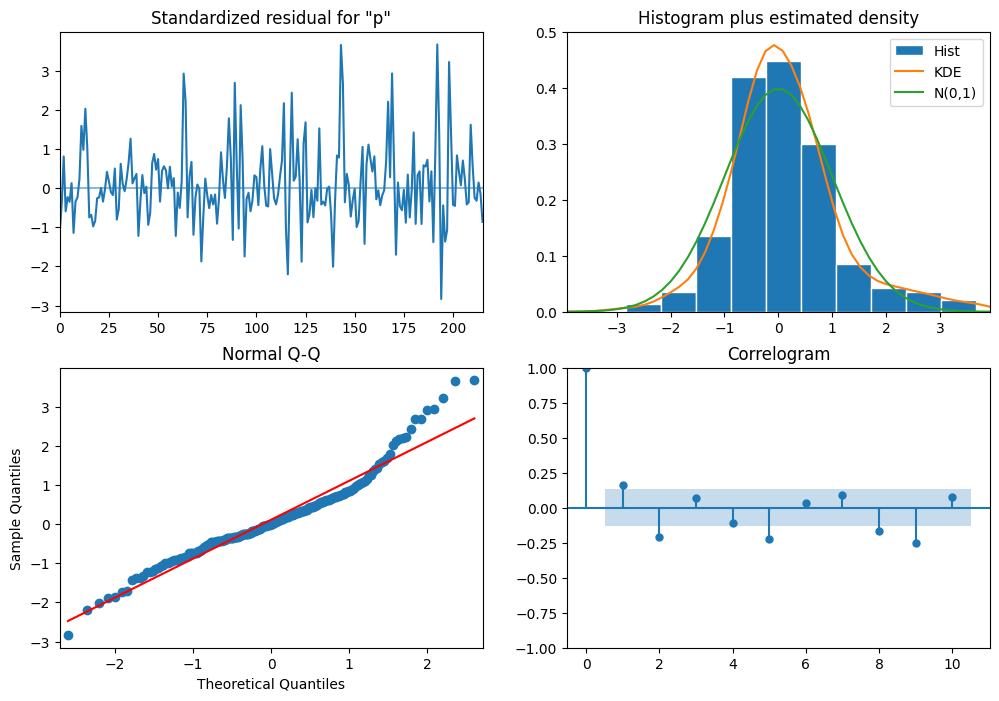

In [ ]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# Fit an ARMA(1,1) model
ARMA11 = ARIMA(weekly_data, order=(1, 0, 1))  # Here (1, 0, 1) represents ARMA(1,1) with no differencing
results_ARMA11 = ARMA11.fit()

# Print the summary of the model results
print(results_ARMA11.summary())

# Optional: Plot the diagnostics to check for any unusual behavior
results_ARMA11.plot_diagnostics(figsize=(12, 8))
plt.show()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:559: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  _index = to_datetime(index)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:559: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  _index = to_datetime(index)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                      
Dep. Variable:                             purches   No. Observations:                  216
Model:             SARIMAX(1, 0, 1)x(0, 1, [], 51)   Log Likelihood               -1173.516
Date:                             Sat, 25 May 2024   AIC                           2353.032
Time:                                     09:42:30   BIC                           2362.314
Sample:                                          0   HQIC                          2356.800
                                             - 216                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9404      0.026     35.512      0.000       0.889       0.992
ma.L1         -0.4780      

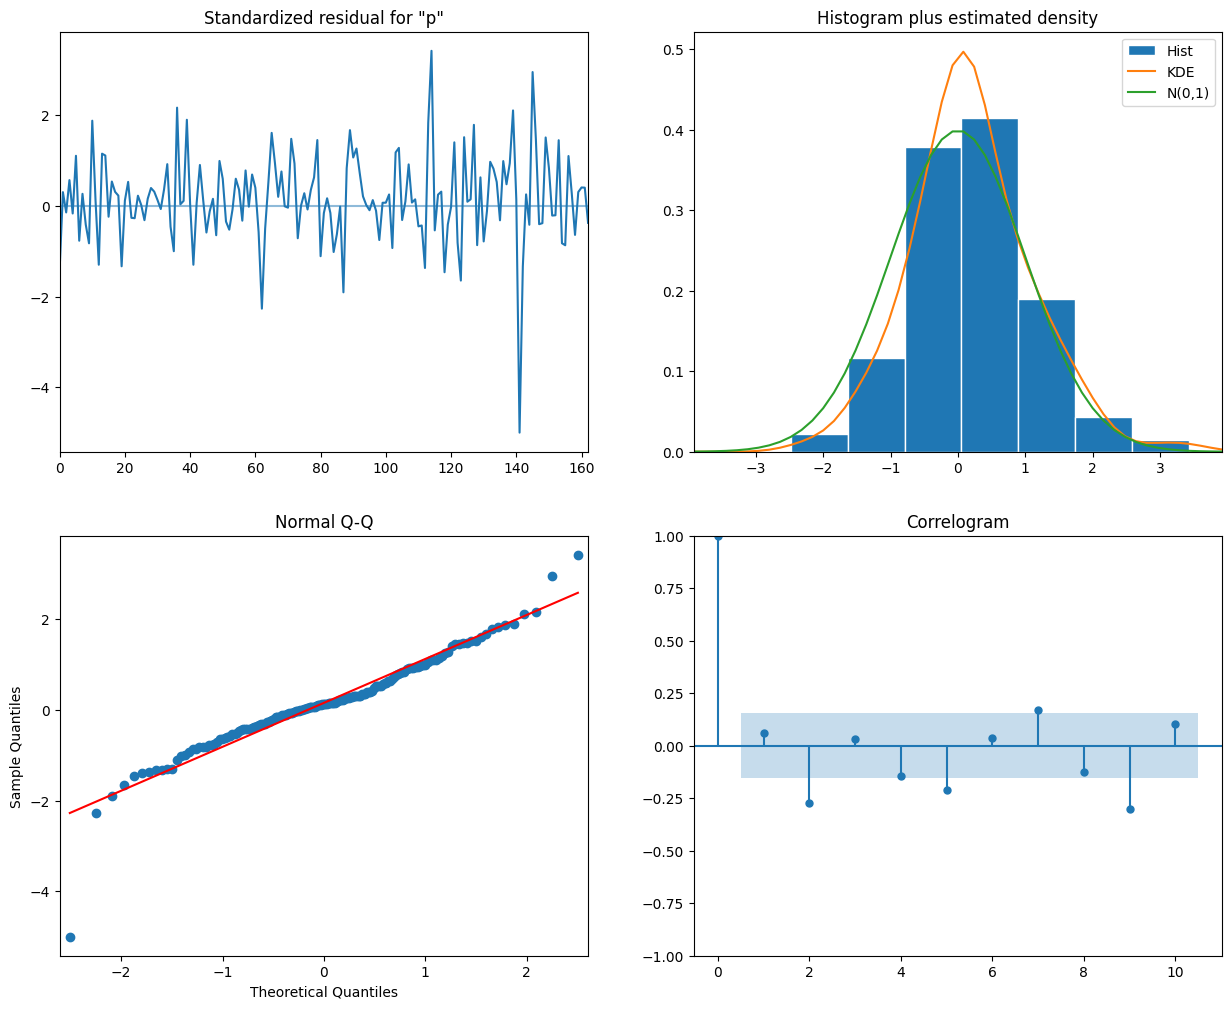

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX



# Example SARIMA model on the data_diff_nonan dataset
SARIMA_D1 = SARIMAX(weekly_data,
                order=(1, 0, 1),
                seasonal_order=(0, 1, 0, 51),  # Seasonal period is 51
                enforce_stationarity=False,
                enforce_invertibility=False)

# Fit the model
SARIMA_D1_results = SARIMA_D1.fit()

# Print the summary of the model
print(SARIMA_D1_results.summary())

# Optional: Plot diagnostics to check for any unusual behavior
SARIMA_D1_results.plot_diagnostics(figsize=(15, 12))
plt.show()


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:559: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  _index = to_datetime(index)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:559: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  _index = to_datetime(index)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                      
Dep. Variable:                             purches   No. Observations:                  216
Model:             SARIMAX(1, 0, 1)x(0, 2, [], 51)   Log Likelihood                -841.638
Date:                             Sat, 25 May 2024   AIC                           1689.276
Time:                                     09:47:53   BIC                           1697.432
Sample:                                          0   HQIC                          1692.585
                                             - 216                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1333      0.214      0.623      0.534      -0.286       0.553
ma.L1          0.3929      

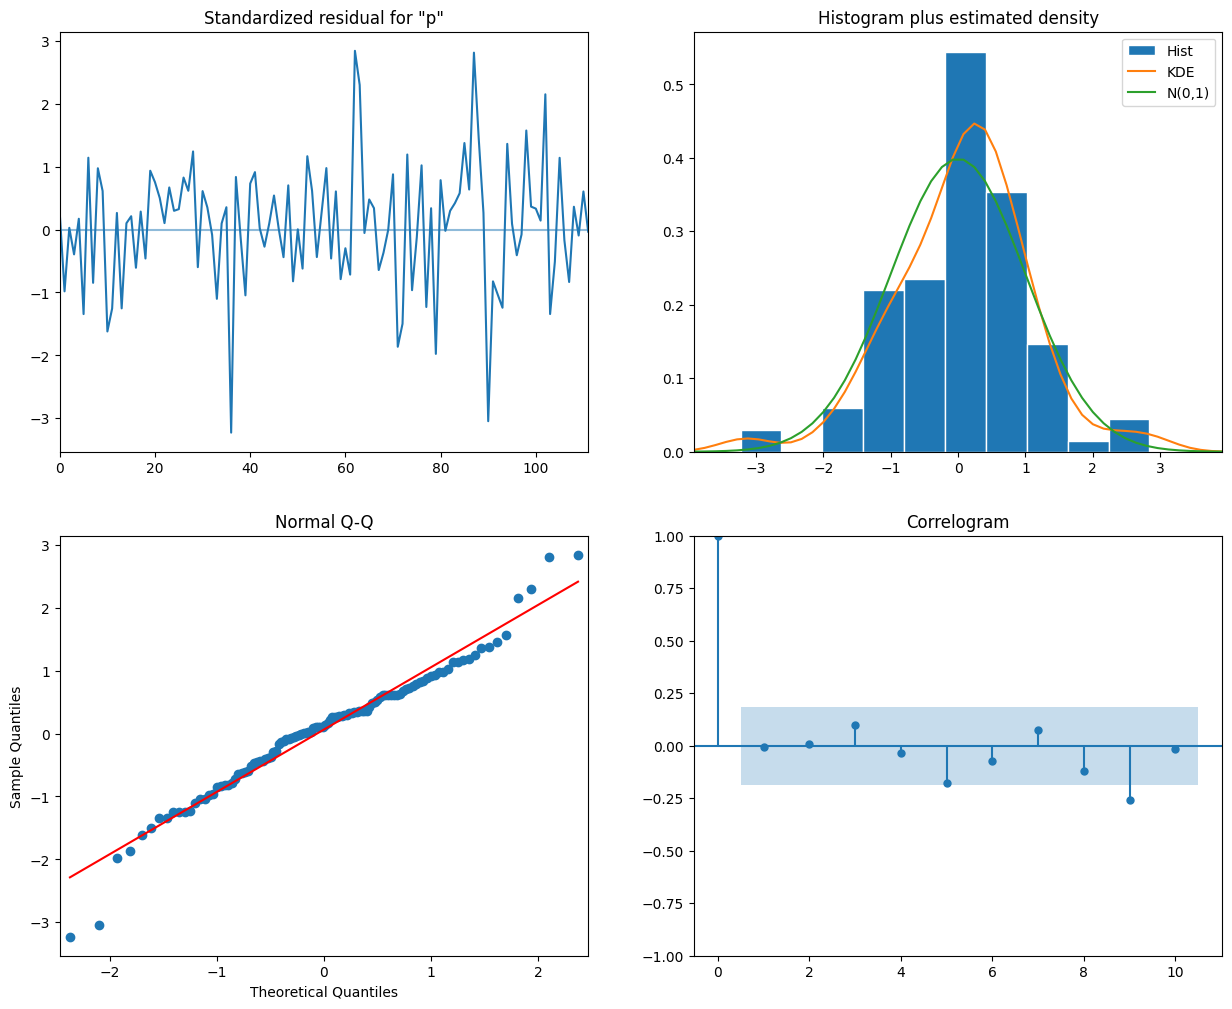

In [ ]:

# Example SARIMA model on the data_diff_nonan dataset
SARIMAD2 = SARIMAX(weekly_data,
                order=(1, 0, 1),
                seasonal_order=(0, 2, 0, 51),  # Seasonal period is 51
                enforce_stationarity=False,
                enforce_invertibility=False)

# Fit the model
SARIMAD2_results = SARIMAD2.fit()

# Print the summary of the model
print(SARIMAD2_results.summary())

# Optional: Plot diagnostics to check for any unusual behavior
SARIMAD2_results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [ ]:
# Number of periods to forecast
forecast_steps = 25

# Forecast using each model
forecast_ARMA11 = results_ARMA11.get_forecast(steps=forecast_steps).predicted_mean
forecast_SARIMA_D1 = SARIMA_D1_results.get_forecast(steps=forecast_steps).predicted_mean
forecast_SARIMA_D2 = SARIMAD2_results.get_forecast(steps=forecast_steps).predicted_mean

# Combine forecasts into a single DataFrame
forecast_df = pd.DataFrame({
    'Historical Data': weekly_data['purches'],
    'Forecast_ARMA11': forecast_ARMA11,
    'Forecast_SARIMA_D1': forecast_SARIMA_D1,
    'Forecast_SARIMA_D2': forecast_SARIMA_D2,
})


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


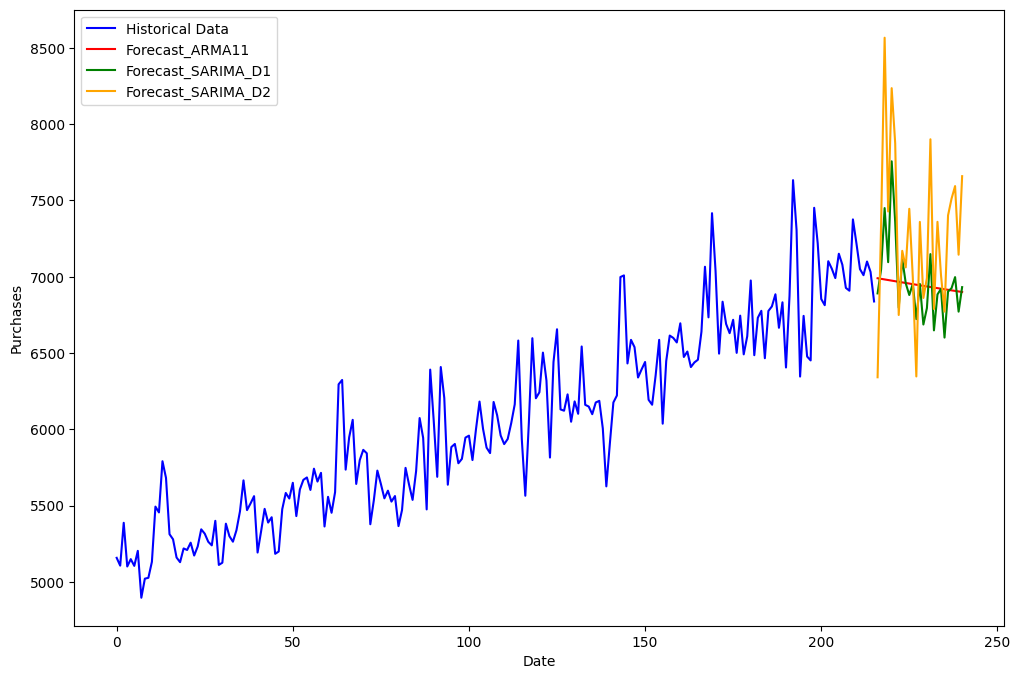

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(weekly_data.index, weekly_data['purches'], label='Historical Data', color='blue')
plt.plot(forecast_ARMA11.index, forecast_ARMA11, label='Forecast_ARMA11', color='red')
plt.plot(forecast_SARIMA_D1.index, forecast_SARIMA_D1, label='Forecast_SARIMA_D1', color='green')
plt.plot(forecast_SARIMA_D2.index, forecast_SARIMA_D2, label='Forecast_SARIMA_D2', color='orange')

# Customize the x-axis to show only one mark per year
#plt.gca().xaxis.set_major_locator(plt.MaxNLocator(nbins=len(weekly_data.index.year.unique())))
#plt.gca().xaxis.set_major_formatter(plt.FixedFormatter(weekly_data.index.year.unique()))

plt.xlabel('Date')
plt.ylabel('Purchases')
plt.legend()
plt.show()


#Prophet

In [ ]:
file_path = '/content/drive/My Drive/project data.csv'
df = pd.read_csv(file_path)
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
weekly_data = df.resample('W-SAT').sum() # Resample the data by week. 'W-SAT' means weeks ending on Saturday.
weekly_data = weekly_data.iloc[1:]  # Remove the first row if it does not represent a complete week
cutoff_date = pd.Timestamp('2020-03-01')# Set cutoff date to remove empty data entries after this point
weekly_data = weekly_data[weekly_data.index < cutoff_date]
weekly_data.rename(columns={'Total credit card purchases in millions of shekels': 'purches'}, inplace=True)

# Prepare the data for Prophet
weekly_data.reset_index(inplace=True)
prophet_data = weekly_data.rename(columns={'date': 'ds', 'purches': 'y'})[['ds', 'y']]


In [ ]:
model = Prophet()
model.add_country_holidays(country_name='IL')
model.fit(prophet_data)


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb4rbtq1l/p4rxx8eu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb4rbtq1l/qk5u7hh3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57982', 'data', 'file=/tmp/tmpb4rbtq1l/p4rxx8eu.json', 'init=/tmp/tmpb4rbtq1l/qk5u7hh3.json', 'output', 'file=/tmp/tmpb4rbtq1l/prophet_model4x913dsw/prophet_model-20240525154908.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:49:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:49:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


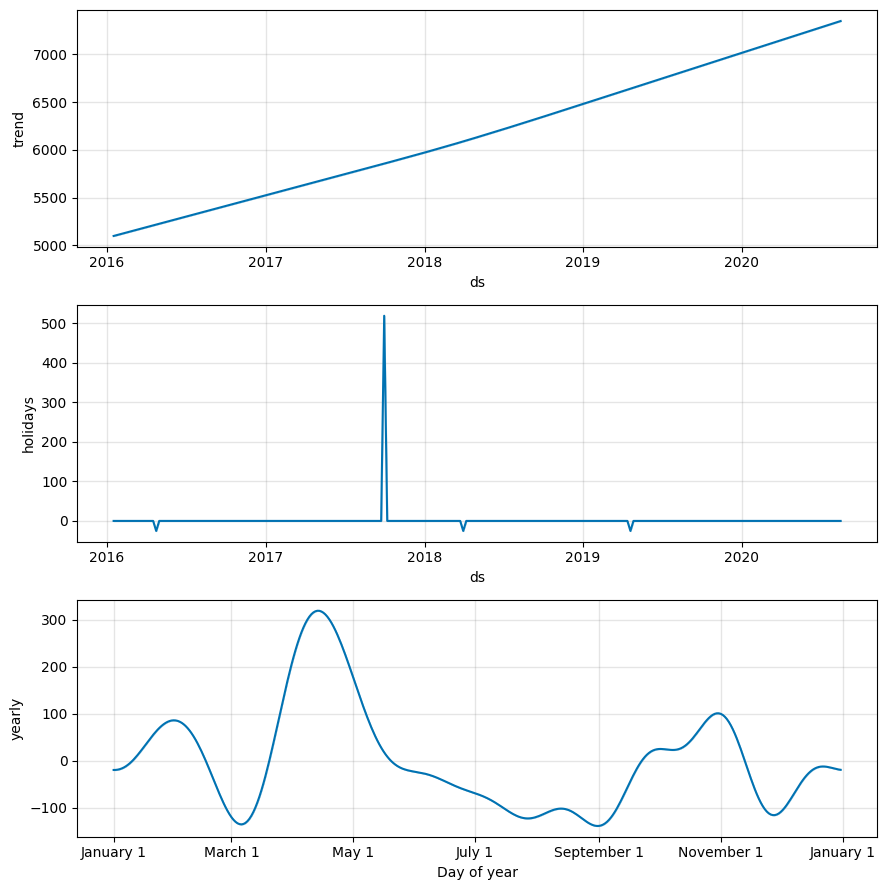

In [ ]:
fig2 = model.plot_components(forecast)
plt.show()

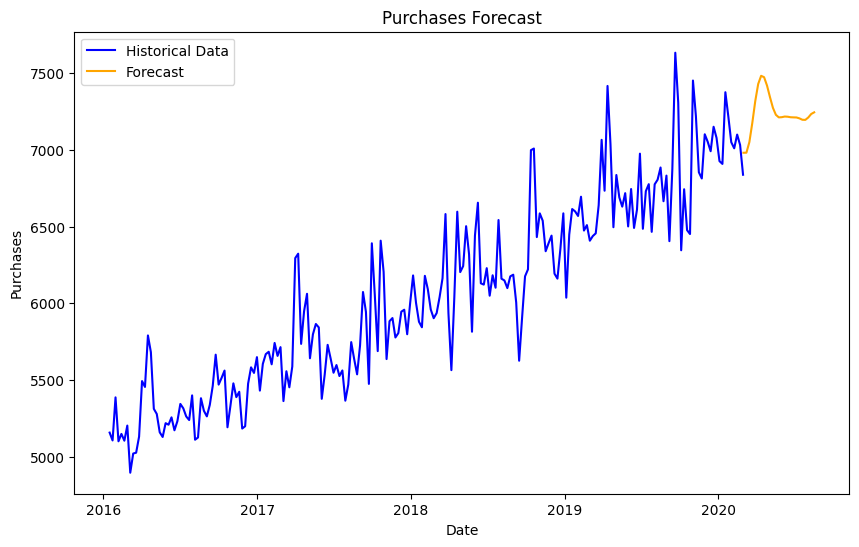

In [ ]:
# Create a DataFrame with future dates
future_dates = model.make_future_dataframe(periods=25, freq='W')

# Make predictions
forecast = model.predict(future_dates)

# Plot the historical data and the forecast starting from the last date of the original data
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(prophet_data['ds'], prophet_data['y'], label='Historical Data', color='blue')

# Filter the forecast to start from the last date of the original data
last_date = prophet_data['ds'].max()
forecast_filtered = forecast[forecast['ds'] > last_date]

ax.plot(forecast_filtered['ds'], forecast_filtered['yhat'], label='Forecast', color='orange')
ax.set_xlabel('Date')
ax.set_ylabel('Purchases')
ax.set_title('Purchases Forecast')
ax.legend()
plt.show()


In [ ]:
forecast_filtered.index

Index([216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229,
       230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240],
      dtype='int64')

#All models on the same plot


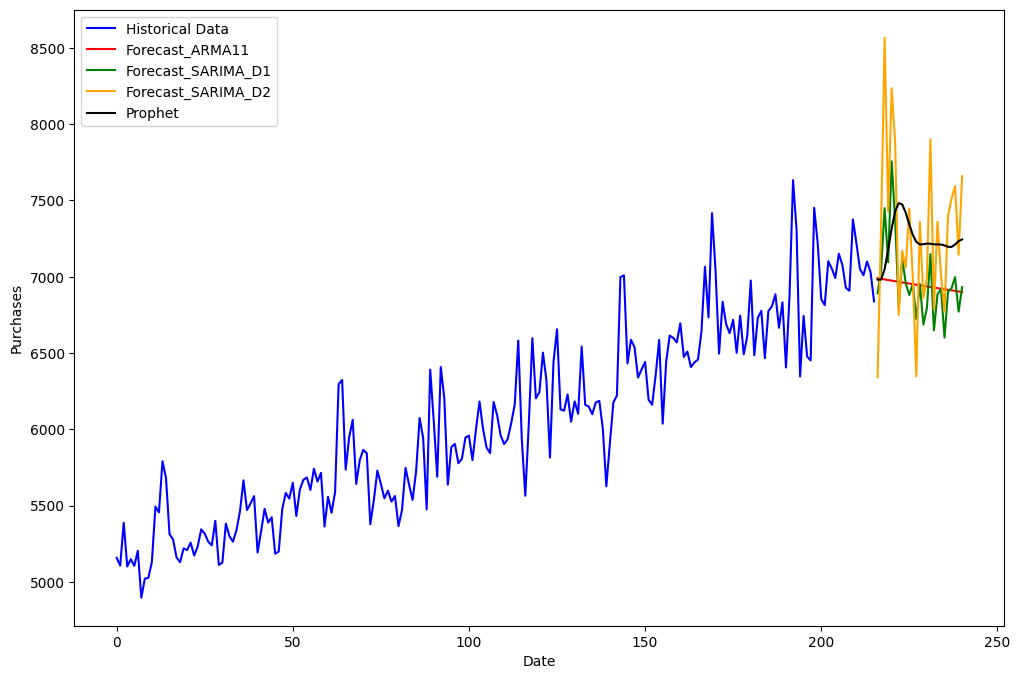

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(weekly_data.index, weekly_data['purches'], label='Historical Data', color='blue')
plt.plot(forecast_ARMA11.index, forecast_ARMA11, label='Forecast_ARMA11', color='red')
plt.plot(forecast_SARIMA_D1.index, forecast_SARIMA_D1, label='Forecast_SARIMA_D1', color='green')
plt.plot(forecast_SARIMA_D2.index, forecast_SARIMA_D2, label='Forecast_SARIMA_D2', color='orange')


plt.plot(forecast_filtered.index, forecast_filtered['yhat'], label='Prophet', color='black')
plt.xlabel('Date')
plt.ylabel('Purchases')
plt.legend()
plt.show()
